# Predicting Loan Repayment Outcomes — Lending Club Dataset

## Overview
This project analyzes loan-level data from Lending Club to predict whether a loan will be successfully repaid or end up in a problematic state (late payment, charged off).  
By building a predictive model, we can help lenders make faster, more accurate loan approval decisions and manage risk effectively.

**Dataset Source:** Lending Club Loan public dataset (loans_full_schema.csv)  
**Target Variable:** `loan_status` — transformed into a binary variable:

- **Good**: Fully Paid, Current
- **Bad**: Late (31–120 days), Charged Off, In Grace Period, Default

**Key Steps:**
1. Data exploration and visualization
2. Data cleaning and preprocessing
3. Feature engineering
4. Model training, tuning, and evaluation
5. Insights and business recommendations


### Imports and setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

sns.set_theme(style="whitegrid")

### Load and Inspect Data

We begin by loading the dataset, inspecting column names, data types, and missing values. This allows us to understand the structure of the data and plan our cleaning steps.

In [2]:
# Free license, file added to the project
loan = pd.read_csv('loans_full_schema.csv', index_col=0)

# Quick overview
print(loan.shape)
loan.head()


(10000, 55)


,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
1,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
2,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
3,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
4,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
5,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


## 1. Data exploratory and visualization

First, let us explore distributions of numeric variables, category frequencies, and their relationship with the loan outcome (`loan_status`).

- We begin by visualizing the percentage of missing values.
- Display our target distribution 
- Show some numeric columns and their distribution

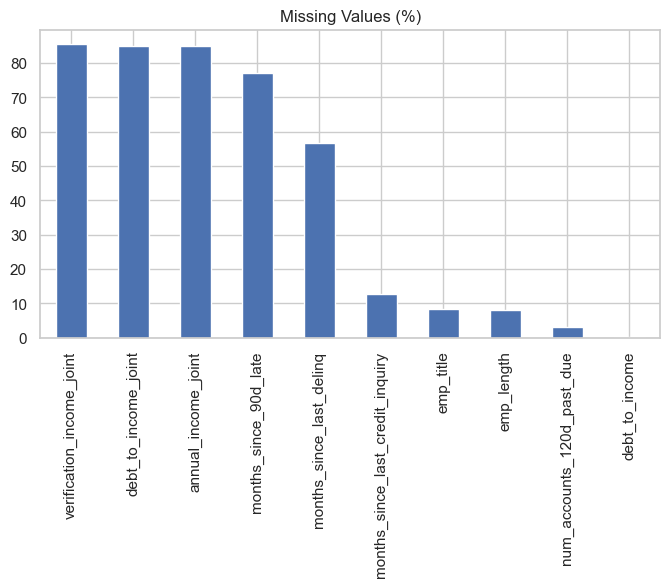

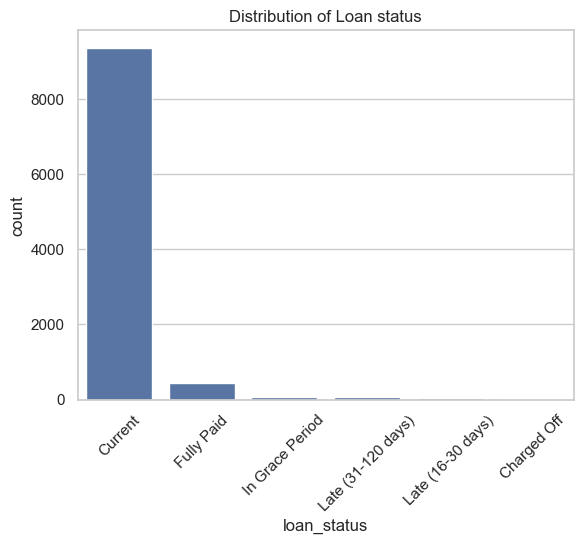

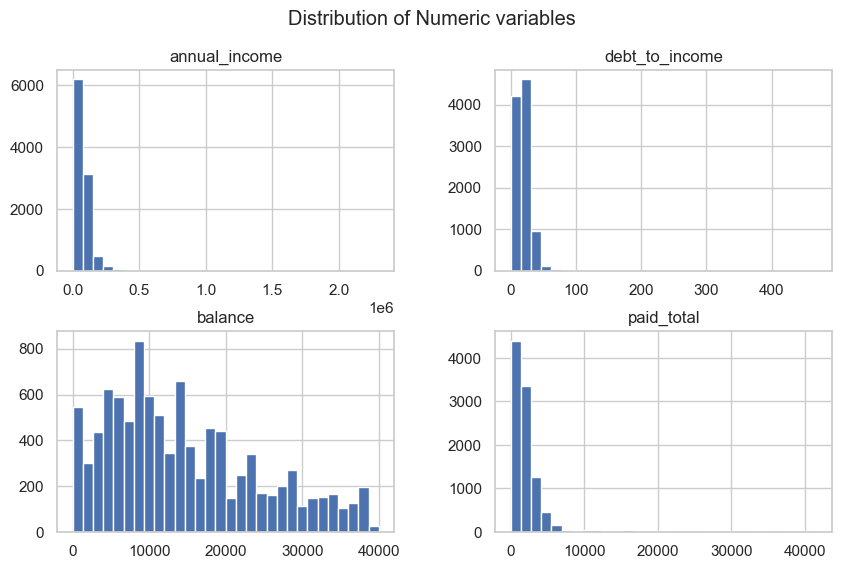

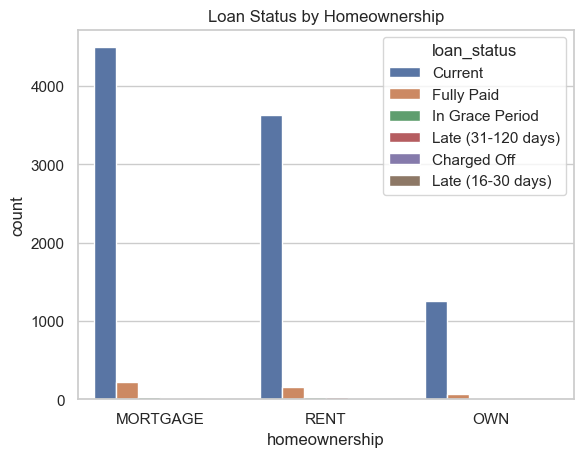

In [3]:
# Graph with missing values
missing = loan.isnull().mean().sort_values(ascending=False)*100
missing[missing > 0].plot(kind='bar', figsize=(8,4), title='Missing Values (%)')
plt.show()

# Target distribution
sns.countplot(x='loan_status', data=loan, order=loan['loan_status'].value_counts().index)
plt.title('Distribution of Loan status')
plt.xticks(rotation=45)
plt.show()

# Numeric quick overview
loan[['annual_income','debt_to_income','balance','paid_total']].hist(bins=30, figsize=(10,6));
plt.suptitle('Distribution of Numeric variables')
plt.show()

# Relationship between homeownwersip and loan status
sns.countplot(x='homeownership', hue='loan_status', data=loan)
plt.title("Loan Status by Homeownership")
plt.show()

From our graphs we can determine:
* Some of the values missing belong to an application type where is determined by a joint and individual applications.
* The distribution shows extreme imbalance between a positive and negative status for our taget.
* In the numeric variables we can confirm skewed distribution in our data
* The distribution of homeownership shows a direct relationship with the current and paid values in our loan status features

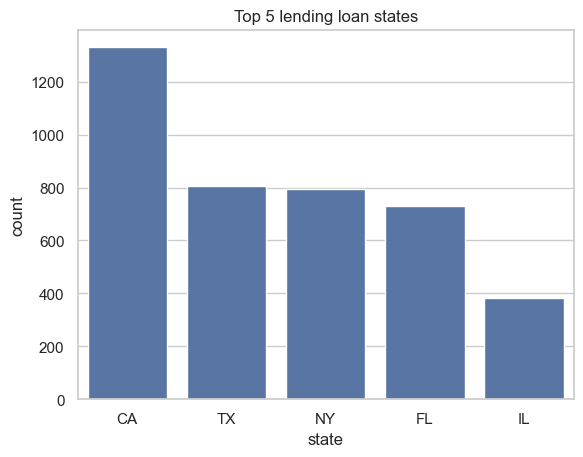

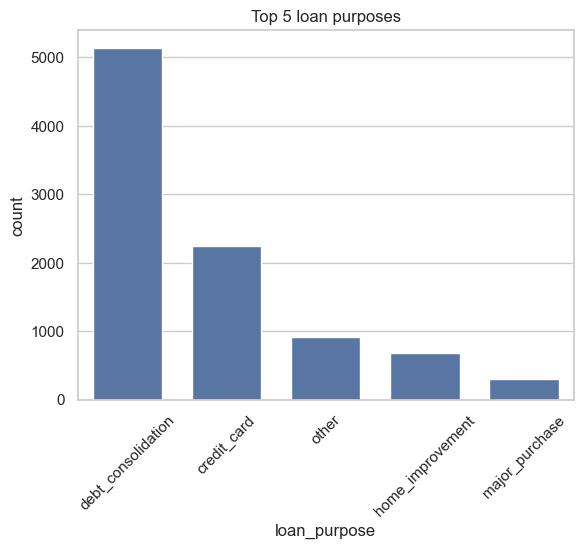

In [4]:
# Overview of top 5 loan approval states
sns.countplot(data=loan, x='state', order=loan['state'].value_counts()[:5].index )
plt.title('Top 5 lending loan states')
plt.show()

# Visualization of loan purposes
sns.countplot(data=loan, x='loan_purpose', order=loan['loan_purpose'].value_counts()[:5].index, width=0.7 )
plt.title('Top 5 loan purposes')
plt.xticks(rotation=45)
plt.show()

* California is the state with top numner of loans approved followed by Texas and New York with little difference.
* The most common purpose of loan application is debt consolidation and credit cards meaning that lenders often open a new loan to finance and pay existing ones.

### Target selection

We want to see the number of values contained in our target and create a binary target type in the dataset.

In [5]:
# Target distribution (loan_status)
print(loan['loan_status'].value_counts(dropna=False))   

loan_status
Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64


In [6]:
# Target column added with the distribution
positive_status = ['Fully Paid', 'Current']
loan['target'] = loan['loan_status'].apply(lambda x: 1 if x in positive_status else 0)
loan['target'].value_counts(normalize=True)


target
1    0.9822
0    0.0178
Name: proportion, dtype: float64

From the previous visualization and number distribution. We can see in our target, there's an imbalanced distribution (0.98 / 0.02) and requires a different approach that we'll handle later.


## 2. Data cleaning and preprocessing

Primarily, we are handling the missing values.

We'll begin by showing the percentage of missing data accross the different features. We want to understand the different approaches we can apply

In [7]:
total_missing = (loan.isnull().sum()).sum()
total_cells = loan.size 
percentage_missing = (total_missing/total_cells)*100

print(f"The percentage of missing values in the dataset is: {percentage_missing:.2f}%")
loan.isna().mean()

The percentage of missing values in the dataset is: 7.53%


emp_title                           0.0833
emp_length                          0.0817
state                               0.0000
homeownership                       0.0000
annual_income                       0.0000
verified_income                     0.0000
debt_to_income                      0.0024
annual_income_joint                 0.8505
verification_income_joint           0.8545
debt_to_income_joint                0.8505
delinq_2y                           0.0000
months_since_last_delinq            0.5658
earliest_credit_line                0.0000
inquiries_last_12m                  0.0000
total_credit_lines                  0.0000
open_credit_lines                   0.0000
total_credit_limit                  0.0000
total_credit_utilized               0.0000
num_collections_last_12m            0.0000
num_historical_failed_to_pay        0.0000
months_since_90d_late               0.7715
current_accounts_delinq             0.0000
total_collection_amount_ever        0.0000
current_ins

We will update some features by filling up the categorical and numerical values.

The numerical features are updated with the median value to handle outliers and skewness

In [8]:
# Updating columns with categorical and numerical missing values
loan['emp_title'] = loan['emp_title'].fillna('Unknown')

# Columns updated with median value to handle outliers
loan['emp_length'] = loan['emp_length'].fillna(loan['emp_length'].median())
loan['debt_to_income'] = loan['debt_to_income'].fillna(loan['debt_to_income'].median())
loan['months_since_last_credit_inquiry'] = loan['months_since_last_credit_inquiry'].fillna(loan['months_since_last_credit_inquiry'].median())


Update `verified income` as a binary category, also drop any single value column

In [9]:
# Drop feature with single value
single_value = [i for i in loan.columns if loan[i].nunique() <=1]
loan = loan.drop(columns=single_value)

# Update categorical feature with comprehensible value
loan['verified_income'] = loan['verified_income'].replace('Source Verified','Verified')
loan['annual_income_joint'] = loan['annual_income_joint'].fillna(0)

Finally, drop columns with a high percentage of missing values based on a high treshold value (70%)

In [10]:
# Set percentage of missing value to drop features non treated
treshold = 0.30
missing_pct = loan.isnull().mean()
columns_missing = missing_pct[missing_pct > treshold].index.tolist()

# Drop and update columns with missing values
loan = loan.drop(columns=columns_missing)

# Drop duplicated values
loan = loan.drop_duplicates()

## 3. Feature engineering

Now, we want to create additional variables that may improve model performance:

- `Total income` (annual + joint)
- `Credit history` (from earliest credit line to issue month)
- `Balance to income`
- `Paid ratio`
- `joint account` to handle if the application is joint or individual based on the application type.

In [11]:
# Updating dataset with total income category, based on the income and joint account type
loan['total_income'] = loan['annual_income_joint'] + loan['annual_income']


# Treating date columns to show correct format
loan['issue_month_dt'] = pd.to_datetime(loan['issue_month'], format='%b-%Y')
loan['earliest_credit_line_dt'] = pd.to_datetime(loan['earliest_credit_line'].astype(str) + '-01-01', errors='coerce')
# Credit history in years
loan['credit_history'] = (loan['issue_month_dt'] - loan['earliest_credit_line_dt']).dt.days / 365

# Adding ratio columns based on the information contained
loan['balance_to_income'] = loan['balance'] / (loan['total_income']+1)
loan['paid_ratio'] = loan['paid_total'] / (loan['balance']+1)

# Adding a numeric flag to dataset to show if joint or individual account
loan['joint_account'] = np.where(loan['application_type'].str.lower()== 'joint',1 ,0)

### Feature selection and encoding

Before selecting our features, we want to see the relationsihp between the numerical values through its correlation to make an educated decision.

<Axes: >

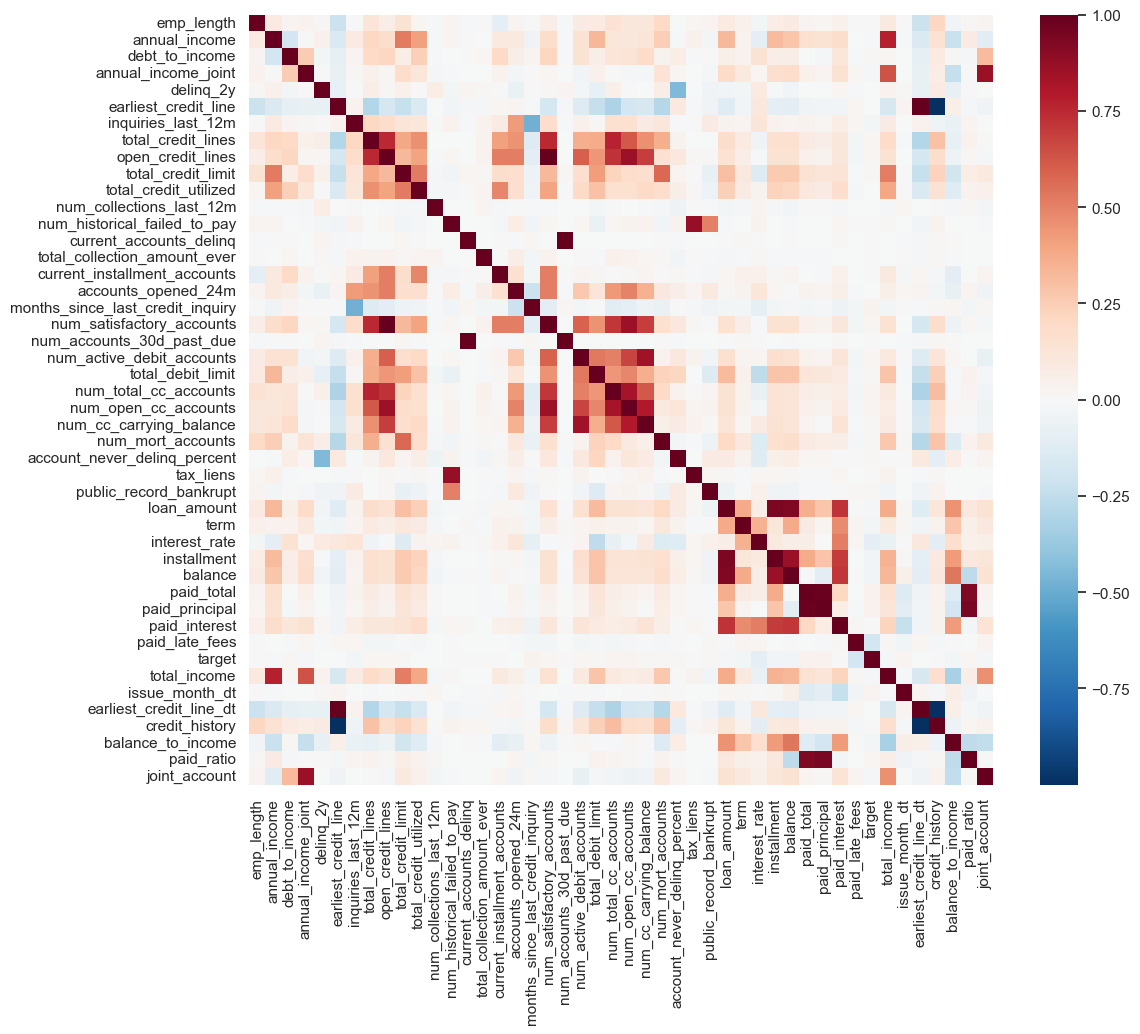

In [12]:
num_cols = [c for c in loan.columns if loan[c].dtype != 'object']

#loan[feature_selection]
plt.figure(figsize=(12,10))
sns.heatmap(loan[num_cols].corr(), cmap="RdBu_r")

Based on the graph we select some of the most relevant features for our prediction along with the encoded features. Later include the categorical columns and encode with OHE.

In [13]:
feature_selection = ['emp_length','homeownership', 'annual_income', 'verified_income','debt_to_income','total_credit_lines', 'total_credit_utilized',
            'current_installment_accounts', 'total_debit_limit', 'num_total_cc_accounts','num_cc_carrying_balance','num_mort_accounts', 
            'initial_listing_status', 'account_never_delinq_percent', 'loan_amount', 'installment', 'balance','paid_total','paid_principal', 
            'paid_interest', 'loan_purpose', 'credit_history', 'total_income', 'paid_ratio', 'balance_to_income', 'joint_account']

feature_selection = [c for c in feature_selection if c in loan.columns]

cat_columns = [c for c in feature_selection if loan[c].dtype == 'object']
loan_ohe = pd.get_dummies(loan[feature_selection], columns=cat_columns, drop_first=True)


## 4. Model training, tuning, and evaluation

Initially we will split our data and instate our model with a class weight parameter. Later, we assign our target feature to `y` and prepare our model to handle with different weights

In [14]:
# Variable assigned with the recently created with one hot encoding feature
X = loan_ohe
y = loan['target']

In [15]:
# Start by splitting the target column in the training ans testing variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model adjusted with a balanced class to handle target accordingly with the negative values
class_weights = {0: 10, 1: 1}  
rf = RandomForestClassifier(random_state=42, class_weight=class_weights)

We start by training a Forest Model and use GridSearchCV to find optimal parameters

In [16]:
# Adjust some parameters for GridSearch for model
params = {'n_estimators': [100,200], 'max_depth':[5,10,None]}
# Initialize our GridSearch and assing the model to estimator, additionally set the scoring method to f1 to have a more balanced results
grid = GridSearchCV(estimator=rf, param_grid=params, cv=4, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*60)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print('-'*60)
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

Accuracy: 0.986
------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.36        36
           1       0.99      1.00      0.99      1964

    accuracy                           0.99      2000
   macro avg       0.99      0.61      0.68      2000
weighted avg       0.99      0.99      0.98      2000

------------------------------------------------------------
AUC-ROC: 0.6111111111111112


Our classification report shows an *AUC-ROC* *(Receiver Operating Characteristic)* performing with a score of 0.61, however altogether indicates the current model is struggling to distinguish between positive and negative classes. This is confirmed with the *recall* and *f1-score* results where 78% of predictions are incorrect and 64% are captures of the actual negatives (0).

With this in mind, will run some adjustments. First will visualize the current features and its importance in the model. Later will adjust some parameters in the model to determine if this approach improves our model.

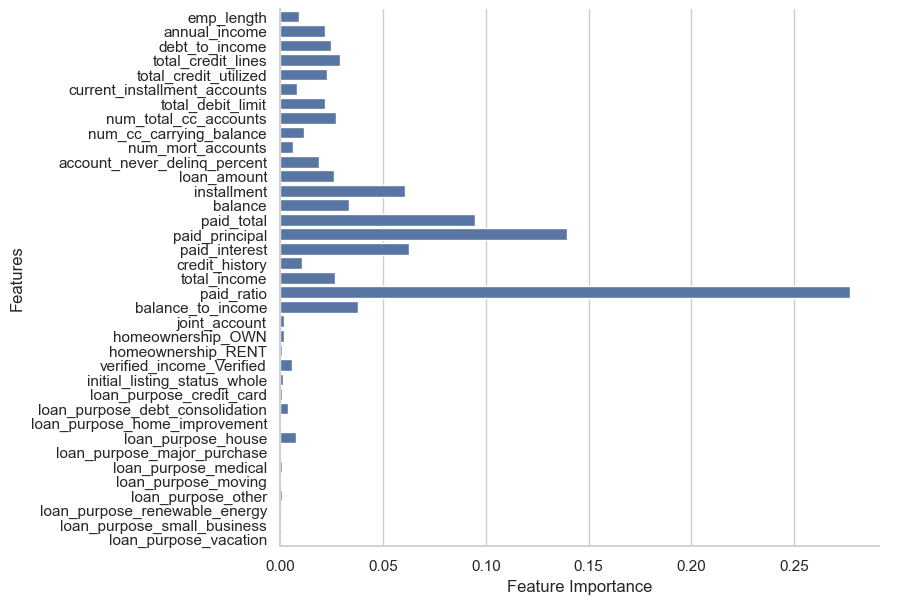

In [17]:
# Get feature importances
feature_importances = best_model.feature_importances_
sns.catplot(x=feature_importances, y=X_train.columns, kind='bar', aspect=1.5, height=6)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

As we can see, some features are not having a direct impact in the model prediction, we will list those relevants and re train the data with the new selection.

In [18]:
new_selection = ['emp_length', 'annual_income', 'debt_to_income','total_credit_lines', 'total_credit_utilized',
            'current_installment_accounts', 'total_debit_limit', 'num_total_cc_accounts','num_cc_carrying_balance','num_mort_accounts', 
            'account_never_delinq_percent', 'loan_amount', 'installment', 'balance','paid_total','paid_principal', 
            'paid_interest', 'credit_history', 'total_income', 'paid_ratio', 'balance_to_income', 'joint_account']

new_selection = [c for c in new_selection if c in loan.columns]

cat_cols = [c for c in new_selection if loan[c].dtype == 'object']
new_ohe = pd.get_dummies(loan[new_selection], columns=cat_cols, drop_first=True)

X = new_ohe
y = loan['target']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Increase the class weights to add more penalty to the negatives
class_weights = {0: 20, 1: 1}

rf = RandomForestClassifier(random_state=42, class_weight=class_weights)

params = {'n_estimators': [100,200], 'max_depth':[5,10,None]}

grid = GridSearchCV(estimator=rf, param_grid=params, cv=4, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*60)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print('-'*60)
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.984
------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.31      0.41        36
           1       0.99      1.00      0.99      1964

    accuracy                           0.98      2000
   macro avg       0.80      0.65      0.70      2000
weighted avg       0.98      0.98      0.98      2000

------------------------------------------------------------
AUC-ROC: 0.6509957003847024
[[  11   25]
 [   7 1957]]


In comparison with the initial test, we can see a drop in the precision of 39% when detecting negative class. But in contrast we have an increase of 9% in the recall and 5% in the f1.
Our AUC-ROC had an in increase to 0.65 too. 

This means that the model catches only a low percentage of the "bad" loans and it has difficulty differentiating a negative loan. Also, by including a confusion matrix we can see the number of false positives and false negatives.

[ 11  `25`]  <- Negatives (0): 11 correctly flagged, 25 missed 

[ `7` 1957] <- Positives (1): Almost all good loans correctly classified


### Tuning and Evaluation

One additional adjustment we can make is to implement a Pipeline including two models to handle imbalanced datasets: **SMOTEENN** and **Balanced Random Forest** and repeating the test with the **Grid Search**. This is so we can tune the model with a more robust iteration.

In [20]:
#from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier

# Create a pipeline with SMOTE and Random Forest
pipeline = Pipeline([
    ('smote', SMOTEENN(random_state=42, sampling_strategy='minority')),
    ('brf', BalancedRandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Define parameter grid
params = {
    'brf__n_estimators': [100, 200],
    'brf__max_depth': [5, 10, None]
}

# Grid search with SMOTE
grid = GridSearchCV(pipeline, params, cv=4, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print('-'*60)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print('-'*60)
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.964
------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.31      0.23        36
           1       0.99      0.98      0.98      1964

    accuracy                           0.96      2000
   macro avg       0.59      0.64      0.61      2000
weighted avg       0.97      0.96      0.97      2000

------------------------------------------------------------
AUC-ROC: 0.6408124009957005
[[  11   25]
 [  47 1917]]


While we have a high accuracy, this metric is not meaningful since the target is composed of a 98% good loans. In contrast, the model gained in *recall* for class 0 (31%), meaning the model identifies more risky loans, though still missing some. The *AUC-ROC* of 0.64 shows a moderate separation ability between classes. This reflects the difficulty of predicting defaults with highly imbalanced data.

The tuned model sacrifices a small amount of accuracy to better detect minority bad loan cases.

### Conclusion

This project demonstrates a practical machine learning workflow for credit risk modeling on **Lending Club’s public loan** dataset. Through extensive preprocessing, feature engineering (credit history, income-to-loan ratios), and class imbalance handling with *SMOTEENN* and *Balanced Random Forests*, we achieved:

- A robust model that correctly identifies a subset of high-risk loans while maintaining strong overall classification performance.
- A pipeline that prioritizes recall for risky loans, which is more valuable to lenders than overall accuracy.
- A transparent evaluation approach that highlights the limitations of accuracy on highly imbalanced datasets.

This process reflects real-world challenges in lending analytics: rare default events, noisy borrower information, and the cost sensitivity of false negatives.

## 5. Insights and business recommendations

### Model Performance Overview

After experimenting with multiple models and imbalance-handling techniques, we implemented a **SMOTEENN + Balanced Random Forest** pipeline with hyperparameter tuning via `GridSearchCV`.  
This pipeline combines **oversampling and cleaning of minority class samples (SMOTEENN)** with a **Balanced Random Forest Classifier** that assigns equal weight to both classes.

**Performance on Test Set (n = 2000 loans):**

| Metric                  | Class 0 (Bad Loans) | Class 1 (Good Loans) | Overall |
|-------------------------|--------------------|---------------------|---------|
| Precision               | 0.19               | 0.99                | -       |
| Recall                  | 0.31               | 0.98                | -       |
| F1-score                | 0.23               | 0.98                | -       |
| Accuracy                | -                  | -                   | **96.4%** |
| AUC-ROC                 | -                  | -                   | **0.64** |


**Confusion Matrix:**

[`[11  25]`    <- Bad loans: 11 correctly flagged, 25 missed  
`[47   1917]`] <- Good loans: Almost all correctly classified



### Key Insights:

- The dataset is **highly imbalanced** (~98% “good” loans, ~2% “bad” loans).  
- Earlier models achieved >98% accuracy by predicting most loans as “good,” but added little value for **identifying risky borrowers**.  
- This tuned pipeline improves **recall for Class 0 (bad loans)** to 31%, meaning the model is detecting more high-risk loans at the expense of a small drop in accuracy.  
- **AUC-ROC of 0.64** indicates moderate separation between safe and risky loans, showing there is predictive signal but also room for improvement.  
- These results highlight the **real-world challenge** of imbalanced credit risk modeling, where rare default events are difficult to predict.

### Business Recommendations:

From a financial services perspective:  
- False negatives (approving risky loans) are more costly than false positives (flagging good loans for review).  
- The model is now **tuned for higher sensitivity to risky loans**, which aligns with risk management goals.  
- Even small improvements in recall for bad loans can translate to significant **cost savings** for lenders.

### Next Steps:

1. **Cost-Based Optimization**  
   Adjust probability thresholds and scoring functions to prioritize **minimizing false negatives** over raw accuracy.

2. **Advanced Models**  
   Test **XGBoost, LightGBM, and CatBoost**, which are well-suited for imbalanced classification.

3. **Refined Sampling Strategy**  
   Explore SMOTETomek, undersampling, or cluster-based sampling to reduce synthetic data noise introduced by SMOTEENN.

4. **Feature Enrichment**  
   Engineer more predictive features:
   - Credit utilization ratios
   - Historical payment patterns
   - Borrower-level aggregate metrics

5. **Temporal Validation**  
   Implement a **time-based train/test split** to simulate real-world deployment (train on older loans, test on newer).

### Key Takeaways

   - **Accuracy alone is misleading** in imbalanced financial datasets.  
- By focusing on **recall for bad loans**, the pipeline provides more actionable insights for credit risk teams.  
- This project demonstrates a **full end-to-end ML workflow**:  
  - Data cleaning, imputation, and feature engineering  
  - Class imbalance handling with SMOTEENN and balanced ensembles  
  - Model tuning and fair evaluation  
- The work showcases **domain knowledge** (cost of misclassification, lending risk) and **ML rigor** (balanced evaluation metrics, robust validation strategy).